In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,Flatten, AveragePooling2D, UpSampling2D, Reshape, Dropout,Conv2D
from tensorflow.keras import Sequential,layers,Model
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from tensorflow import keras

In [17]:
images = np.load(r'./img_nn.npy')

In [18]:
images.shape

(73, 150, 600, 180)

In [19]:
dt = 0.02
dx = 0.1
dy = 0.1
D = 1

In [20]:
import cv2

In [7]:
input_ = images[:,:99,:,:].reshape((-1,600,180,1))/255.0

In [8]:
output_ = images[:,1:100].reshape((-1,600,180,1))/255.0

In [9]:
output_.shape

(7227, 600, 180, 1)

In [10]:
input3 = np.zeros((7227,1))

In [11]:
def xx_filter(shape, dtype=None):

    f = np.array([
            [[[0]], [[0]], [[0]]],
            [[[1]], [[-2]], [[1]]],
            [[[0]], [[0]], [[0]]]
        ])
    return tf.constant(f,dtype='float32')
#     assert f.shape == shape
#     return K.variable(f, dtype='float32')

def yy_filter(shape, dtype=None):

    f = np.array([
            [[[0]], [[1]], [[0]]],
            [[[0]], [[-2]], [[0]]],
            [[[0]], [[1]], [[0]]]
        ])
    return tf.constant(f, dtype='float32')

In [12]:
def bulid_xx_derivate(dx):
    input_tensor = Input(shape=(600,180,1))

    x = layers.Conv2D(filters=1, 
                      kernel_size = 3,
                      kernel_initializer=xx_filter,
                      strides=1, 
                      padding='same') (input_tensor)
    
  

    model = Model(inputs=input_tensor, outputs=dt*x/(dx**2))
    return model

def bulid_yy_derivate(dy):
    input_tensor = Input(shape=(600,180,1))

    y = layers.Conv2D(filters=1, 
                      kernel_size = 3,
                      kernel_initializer=yy_filter,
                      strides=1, 
                      padding='same') (input_tensor)
    


    model = Model(inputs=input_tensor, outputs=dt* y/(dy**2))
    return model

In [27]:
inputs1 = Input(shape=(600,180,1))

inputs3 = Input(shape=(1))

point_wise_model = Sequential()
point_wise_model.add(Dense(16,input_shape=(1, )))
point_wise_model.add(Dense(16,activation='relu'))
point_wise_model.add(Dense(1))


diffusion_model = Sequential()
diffusion_model.add(Dense(16,input_shape=(1,),activation='relu'))
diffusion_model.add(Dense(1,activation='sigmoid'))

model_xx = bulid_xx_derivate(dx)
model_yy = bulid_yy_derivate(dy)


    
model_xx.layers[1].trainable = False
model_yy.layers[1].trainable = False

xx_derivate = model_xx(inputs1)
yy_derivate = model_yy(inputs1)

lap = xx_derivate+yy_derivate




model = Sequential()

R1 = layers.Lambda(lambda x: dt*x*(1-x))(inputs1)


D1 = 0.0035*diffusion_model(inputs3)


D3 = layers.Multiply()([D1,lap])



#batch_size, dim1,dim2,dim3 = tf.shape(inputs1)
#flat_inputs = tf.reshape(inputs1, shape=(batch_size * dim1*dim2, 1))
flat_inputs = tf.reshape(inputs1, shape=(-1, 1))
flat_outputs = point_wise_model(flat_inputs)
R2 = tf.reshape(flat_outputs, shape=(-1,600,180,1))

R3 = layers.Multiply()([R1, R2])


outputs = layers.Add()([R3, D3, inputs1])

In [28]:
model = Model(inputs=[inputs1, inputs3], outputs=[outputs])

In [29]:
pp1 = keras.models.load_model("pointwise/p1")

In [30]:
pw = pp1.get_weights()

In [31]:
model.layers[3].set_weights(pw) 

In [32]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mae'])
            

In [33]:
history = model.fit([input_,input3], output_,
                    batch_size=512,
                    epochs=1,
                    validation_split=0.3)


10/10 [==============================] - 43s 4s/step - loss: 0.0010 - mae: 0.0062 - val_loss: 8.2938e-04 - val_mae: 0.0051


In [34]:
diffusion_model.predict((1,))

array([[0.5473964]], dtype=float32)

Text(0, 0.5, 'potential V(u)')

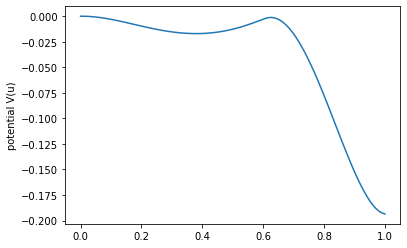

In [35]:
u = np.linspace(0,1,100)

reaction = point_wise_model.predict(u).reshape(u.shape[0])*dt*(-u)*(1-u)

reaction_integral = np.zeros_like(reaction)

for i in range(100):
    reaction_integral[i] = np.sum(reaction[0:i])
    
plt.plot(u,reaction_integral)

plt.ylabel('potential V(u)')

Text(0, 0.5, 'potential V(u)')

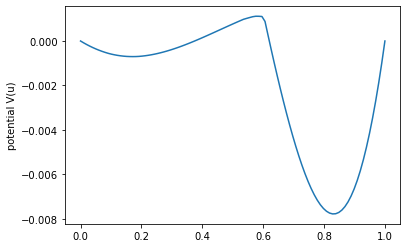

In [36]:
reaction = point_wise_model.predict(u).reshape(u.shape[0])*dt*(-u)*(1-u)
plt.plot(u,reaction)

plt.ylabel('potential V(u)')

In [37]:
def pde_pred(model,u):
    u1 = 1
    u1 = np.array(u1)
    u1 = u1.reshape((1,1))
    udt = model.predict([u,u1])
    return udt
    
def pred(model,u,n):
    for i in range(n):
        u = pde_pred(model,u)
    return u

In [38]:
def plot_images(*images):
    fig, ax = plt.subplots(1, len(images), figsize=(3*len(images), 4))
    for a, i in zip(ax, images):
        im = a.imshow(np.squeeze(i), vmin=0, vmax=1)
        a.axis('off')
        #fig.colorbar(im, ax=a)
       # a.set_xlim([0, 180])
       # a.set_ylim([600, 0])

In [ ]:
ncuts = 20
cut = images[ncuts,0,:,:].reshape((1,600,180,1))/255.0

plot_images(cut,images[ncuts,20,:,:]/255.0,images[ncuts,40,:,:]/255.0,images[ncuts,60,:,:]/255.0,images[ncuts,80,:,:]/255.0,images[ncuts,100,:,:]/255.0,images[ncuts,120,:,:]/255.0)        

plot_images(cut,pred(model,cut,20),pred(model,cut,40),pred(model,cut,60),pred(model,cut,80),pred(model,cut,100),pred(model,cut,120))


In [ ]:
ncuts = 13
cut = images[ncuts,0,:,:].reshape((1,600,180,1))/255.0

plot_images(cut,images[ncuts,20,:,:]/255.0,images[ncuts,40,:,:]/255.0,images[ncuts,60,:,:]/255.0,images[ncuts,80,:,:]/255.0,images[ncuts,100,:,:]/255.0,images[ncuts,120,:,:]/255.0)        

plot_images(cut,pred(model,cut,20),pred(model,cut,40),pred(model,cut,60),pred(model,cut,80),pred(model,cut,100),pred(model,cut,120))


In [ ]:
ncuts = 67
cut = images[ncuts,0,:,:].reshape((1,600,180,1))/255.0

plot_images(cut,images[ncuts,20,:,:]/255.0,images[ncuts,40,:,:]/255.0,images[ncuts,60,:,:]/255.0,images[ncuts,80,:,:]/255.0,images[ncuts,100,:,:]/255.0,images[ncuts,120,:,:]/255.0)        

plot_images(cut,pred(model,cut,20),pred(model,cut,40),pred(model,cut,60),pred(model,cut,80),pred(model,cut,100),pred(model,cut,120))


In [ ]:
ncuts = 65
cut = images[ncuts,0,:,:].reshape((1,600,180,1))/255.0

plot_images(cut,images[ncuts,20,:,:]/255.0,images[ncuts,40,:,:]/255.0,images[ncuts,60,:,:]/255.0,images[ncuts,80,:,:]/255.0,images[ncuts,100,:,:]/255.0,images[ncuts,120,:,:]/255.0)        

plot_images(cut,pred(model,cut,20),pred(model,cut,40),pred(model,cut,60),pred(model,cut,80),pred(model,cut,100),pred(model,cut,120))


In [ ]:
ncuts = 45
cut = images[ncuts,0,:,:].reshape((1,600,180,1))/255.0

plot_images(cut,images[ncuts,20,:,:]/255.0,images[ncuts,40,:,:]/255.0,images[ncuts,60,:,:]/255.0,images[ncuts,80,:,:]/255.0,images[ncuts,100,:,:]/255.0,images[ncuts,120,:,:]/255.0)        

plot_images(cut,pred(model,cut,20),pred(model,cut,40),pred(model,cut,60),pred(model,cut,80),pred(model,cut,100),pred(model,cut,120))


In [ ]:
ncuts = 36
cut = images[ncuts,0,:,:].reshape((1,600,180,1))/255.0

plot_images(cut,images[ncuts,20,:,:]/255.0,images[ncuts,40,:,:]/255.0,images[ncuts,60,:,:]/255.0,images[ncuts,80,:,:]/255.0,images[ncuts,100,:,:]/255.0,images[ncuts,120,:,:]/255.0)        

plot_images(cut,pred(model,cut,20),pred(model,cut,40),pred(model,cut,60),pred(model,cut,80),pred(model,cut,100),pred(model,cut,120))
